In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import wandb
wandb.login()
from sklearn.metrics import accuracy_score, precision_score, roc_curve, confusion_matrix

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [25]:
# Define the dataset directories and other parameters
train_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/augmented_train_test_100/train/"
test_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/augmented_train_test_100/test"
val_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/augmented_train_test_100/eval/"
batch_size = 32

# Define the transformations for the dataset
# Create a transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# Create the ImageFolder datasets
train_dataset = ImageFolder(root=train_dir, transform=manual_transforms)
test_dataset = ImageFolder(root=test_dir, transform=manual_transforms)
val_dataset = ImageFolder(root=val_dir, transform=manual_transforms)

# Get the list of class names
class_names = train_dataset.classes

# Get the total number of samples in each dataset
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)
num_val_samples = len(val_dataset)

# Create DataLoaders for each dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(len(class_names))


3514


In [26]:
#len of valçdataloader
len(val_dataloader),len(train_dataloader), len(test_dataloader)

(10982, 11092, 11092)

In [27]:
# Get a set of pretrained model weights
weights = torchvision.models.DenseNet201_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [28]:
Dense_net = models.densenet201(weights=weights)

# Freeze model parameters
for param in Dense_net.parameters():
    param.requires_grad = False

Dense_net.classifier

Linear(in_features=1920, out_features=1000, bias=True)

In [29]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
Dense_net.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1920,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [30]:
# Convert model to be used on GPU
Dense_net = Dense_net.to('cuda:0')

TO DO : 
    plot in weight and bias those metrics :
        
        Training/Validation loss 

        Accuracy 

        Confusion matrix Train (y_predict_train/y_train) + Confusion matrix Test (y_predict_test/y_test) + Confusion Matrix Eval (y_predict_test/y_test) 

        Precision : TO DO  

        Receiver Operating Characteristic (ROC) 


        73% train/ 37% test on 1 epoch with 50 train and 20 test 

In [31]:
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(Dense_net.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=Dense_net,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_func,
                       epochs=1,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds, this is the results {results}")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [44:41<00:00, 2681.73s/it]

Epoch: 1 | train_loss: 0.8961 | train_acc: 0.8322 | test_loss: 0.2543 | test_acc: 0.9345
[INFO] Total training time: 2681.738 seconds, this is the results {'train_loss': [0.8960769254013744], 'train_acc': [0.8322129688063469], 'test_loss': [0.25427813892063467], 'test_acc': [0.9344769879192211]}


In [36]:
def evaluate(model, dataloader, loss_func, device):
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    eval_precision = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Move inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_func(outputs, targets)
            
            # Accumulate the evaluation loss
            eval_loss += loss.item()
            
            # Calculate evaluation accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Calculate evaluation precision
            eval_precision += torch.sum(predicted == targets).item() / targets.size(0)

    accuracy = 100. * correct / total
    eval_loss /= len(dataloader)
    eval_precision /= len(dataloader)

    return eval_loss, accuracy

In [37]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
import random

run = wandb.init(
    project="DenseNet201",
    tags="101trains_101tests_100evals",
    config={
        "epochs": 5,
        "batch_size": 32,
        "lr": 1e-3,
        "dropout": torch.nn.Dropout(p=0.2, inplace=True),
    })

# Copy your config
config = wandb.config
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(Dense_net.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Define the number of epochs
epochs = 5

# Define early stopping parameters
patience = 2
best_loss = float('inf')
counter = 0

# Setup training and save the results
for epoch in range(epochs):
    # Training code here
    train_loss = 0.0
    correct = 0
    total = 0
    train_precision = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Set the model to training mode
        Dense_net.train()
        
        # Move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = Dense_net(inputs)
        
        # Compute the loss
        loss = loss_func(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Calculate training precision
        train_precision += torch.sum(predicted == targets).item() / targets.size(0)

    accuracy = 100. * correct / total
    train_loss /= len(train_dataloader)
    train_precision /= len(train_dataloader)

    # Log metrics to wandb
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'train_accuracy': accuracy, 'train_precision': train_precision})

    # Test code here
    test_loss = 0.0
    correct = 0
    total = 0
    test_precision = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            # Set the model to evaluation mode
            Dense_net.eval()
            
            # Move inputs and targets to the device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = Dense_net(inputs)
            
            # Compute the loss
            loss = loss_func(outputs, targets)
            
            # Accumulate the test loss
            test_loss += loss.item()
            
            # Calculate test accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Calculate test precision
            test_precision += torch.sum(predicted == targets).item() / targets.size(0)

        # Evaluate on eval dataset
        eval_loss, eval_accuracy = evaluate(Dense_net, val_dataloader, loss_func, device)

    accuracy = 100. * correct / total
    test_loss /= len(test_dataloader)
    test_precision /= len(test_dataloader)

    # Log test metrics to wandb
    wandb.log({'epoch': epoch, 'test_loss': test_loss, 'test_accuracy': accuracy, 'test_precision': test_precision, 'eval_loss': eval_loss, 'eval_accuracy': eval_accuracy})

    # Early stopping
    if eval_loss < best_loss:
        best_loss = eval_loss
        counter = 0
        # Create a simulated model file
        with open("model_Dense_net.h5", "w") as f: f.write("Model: " + str(random.random()))
        # Save the dummy model to W&B
        best_model = wandb.Artifact(f"model_{run.id}", type='model')
        best_model.add_file('model_Dense_net.h5')
        run.log_artifact(best_model)
        # Link the model to the Model Registry
        run.link_artifact(best_model, 'model-registry/My Registered Model')
    else:
        counter += 1
        if counter >= patience:
            break

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

# Finish wandb run
wandb.finish()


[INFO] Total training time: 20212.009 seconds


epoch,▁▁▃▃▅▅▆▆██
eval_accuracy,▁▄▆██
eval_loss,█▄▃▁▁
test_accuracy,▁▃▆▇█
test_loss,█▆▃▂▁
test_precision,▁▃▆▇█
train_accuracy,█▁▅▇█
train_loss,▁█▅▄▃
train_precision,█▁▅▇█
epoch,4
eval_accuracy,93.28401


In [ ]:
# how do i get the F1 score?
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

f1_score_func(outputs, targets)

In [58]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, roc_auc_score

def predict_proba(model, dataloader, device):
    """
    Predict class probabilities for a PyTorch model using a dataloader.

    Args:
        model (nn.Module): PyTorch model to use for prediction.
        dataloader (DataLoader): PyTorch DataLoader object to use for loading data.
        device (str): Device to use for prediction (e.g. "cpu", "cuda").

    Returns:
        numpy.ndarray: Array of predicted class probabilities.
    """
    model.eval()
    probs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs.append(outputs.softmax(dim=1).cpu().numpy())
    probs = np.concatenate(probs, axis=0)
    return probs

# Check if train_targets and train_probs are defined in previous cells
if 'train_targets' not in locals() or 'train_probs' not in locals():
    # Define train_targets and train_probs
    train_probs = predict_proba(model=Dense_net, dataloader=train_dataloader, device=device)
    train_targets = np.concatenate([y for _, y in train_dataloader], axis=0)

# Calculate train_roc_auc
train_roc_auc = roc_auc_score(train_targets, train_probs)

# Calculate val_roc_auc
val_probs = predict_proba(model=Dense_net, dataloader=val_dataloader, device=device)
val_targets = np.concatenate([y for _, y in val_dataloader], axis=0)
val_roc_auc = roc_auc_score(val_targets, val_probs)

# Calculate ROC curves
fpr_train, tpr_train, thresholds_train = roc_curve(train_targets, train_probs)
fpr_val, tpr_val, thresholds_val = roc_curve(val_targets, val_probs)

# Plot ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(fpr_val, tpr_val, label='Validation ROC curve (area = %0.2f)' % val_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [44]:
from typing import List, Tuple

from PIL import Image
from pathlib import Path

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    #model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)


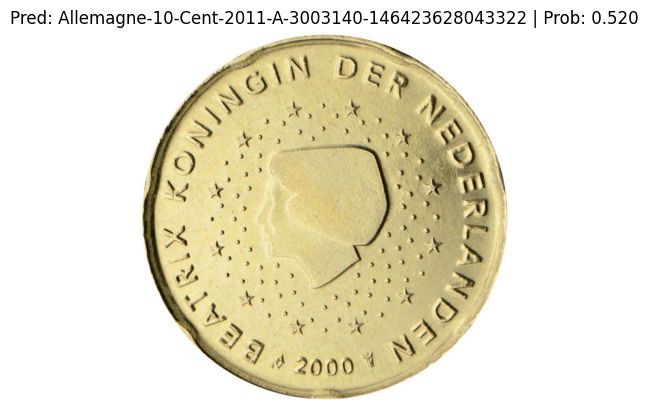

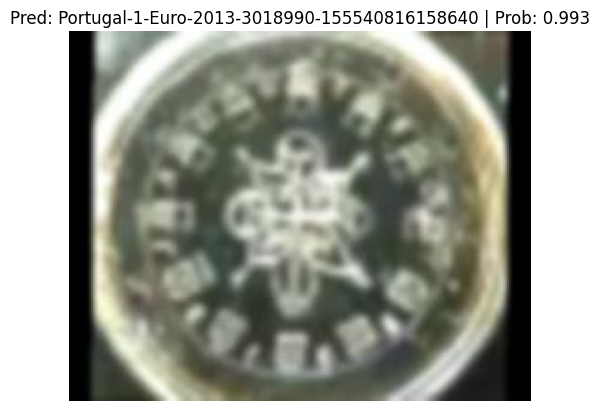

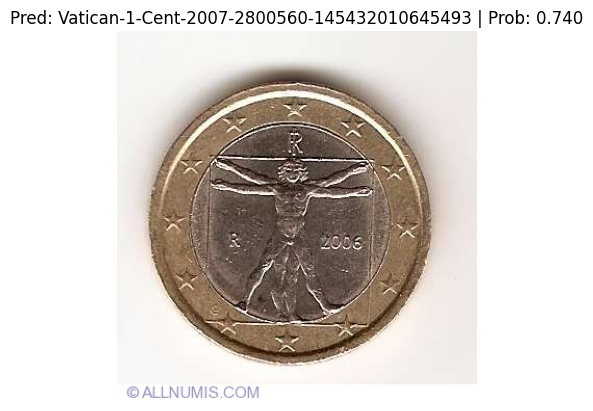

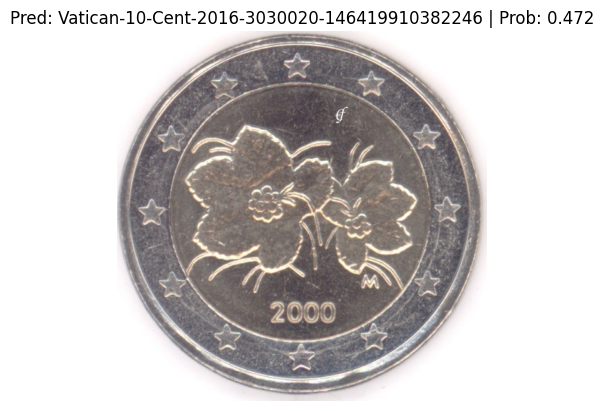

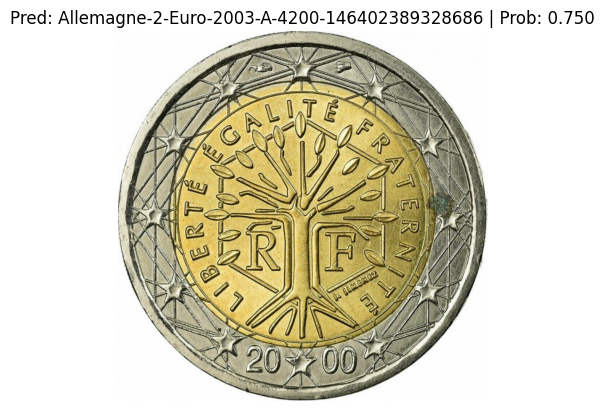

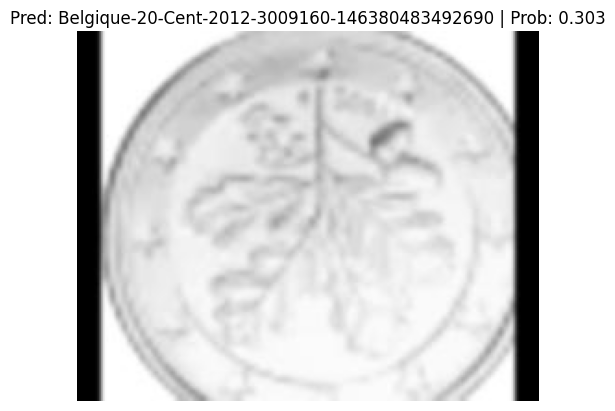

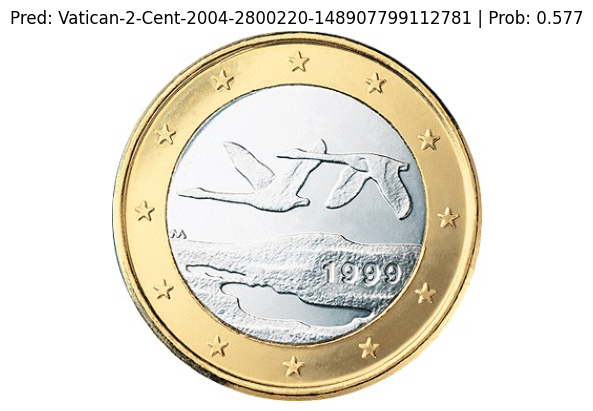

In [57]:
# Get a random list of image paths from test set
import random
from pathlib import Path

image_dir = "/home/abermond/Desktop/workspaces/AICoinXpert/algo/webscraping/data/augmented_only_train/eval/"
unseen_dir = "/home/abermond/Desktop/unseen_coins/"
num_images_to_plot = 7


test_image_path_list = list(Path(unseen_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=Dense_net,
                        image_path=image_path,
                        class_names=class_names,
                        #transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))